In [1269]:
import awkward
import vector
import fastjet
import matplotlib.pyplot as plt
import numpy as np
import bz2
import glob
import matplotlib

import sys
sys.path.append("../../mlpf/")

import jet_utils

In [1471]:
def med_iqr(arr):
    if len(arr) > 0:
        p25 = np.percentile(arr, 25)
        p50 = np.percentile(arr, 50)
        p75 = np.percentile(arr, 75)
    else:
        p25 = 0.0
        p50 = 0.0
        p75 = 0.0
    return p50, p75 - p25

In [1501]:
d = [
    awkward.from_parquet(f)
    for f in sorted(list(glob.glob("/local/joosep/mlpf/clic_edm4hep/p8_ee_tt_ecm380/reco_p8_ee_tt_ecm380_*.parquet")))[:1000]
    # for f in sorted(list(glob.glob("../../reco_p8_ee_tt_ecm380_*.parquet")))
]

d = [awkward.Array({k: di[k] for k in di.fields}) for di in d]
d = awkward.concatenate(d)

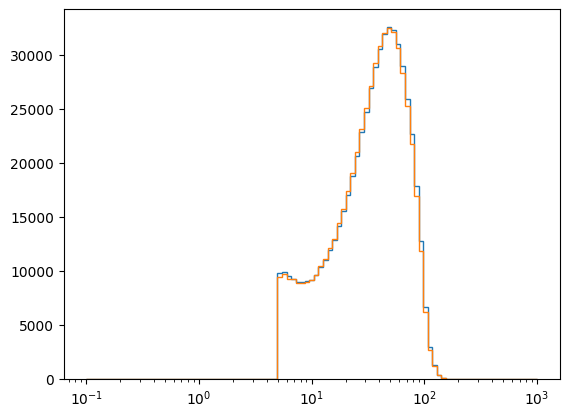

In [1502]:
b = np.logspace(-1,3,100)
plt.hist(awkward.flatten(d["genjet"][:, :, 0]), bins=b, histtype="step", lw=1);
plt.hist(awkward.flatten(d["targetjet"][:, :, 0]), bins=b, histtype="step", lw=1);
plt.xscale("log")
#plt.yscale("log")

In [1503]:
X = awkward.concatenate([d["X_track"], d["X_cluster"]], axis=1)
ygen = awkward.concatenate([d["ytarget_track"], d["ytarget_cluster"]], axis=1)
ycand = awkward.concatenate([d["ycand_track"], d["ycand_cluster"]], axis=1)

In [1504]:
ygen_flat = awkward.flatten(ygen, axis=1)
ygen_flat = ygen_flat[ygen_flat[:, 0]!=0]

In [1505]:
ygen_c = ygen[(X[:, :, 0]==2) & (ygen[:, :, 0]!=0)]
X_c = X[(X[:, :, 0]==2) & (ygen[:, :, 0]!=0)]

ygen_t = ygen[(X[:, :, 0]==1) & (ygen[:, :, 0]!=0)]
X_t = X[(X[:, :, 0]==1) & (ygen[:, :, 0]!=0)]

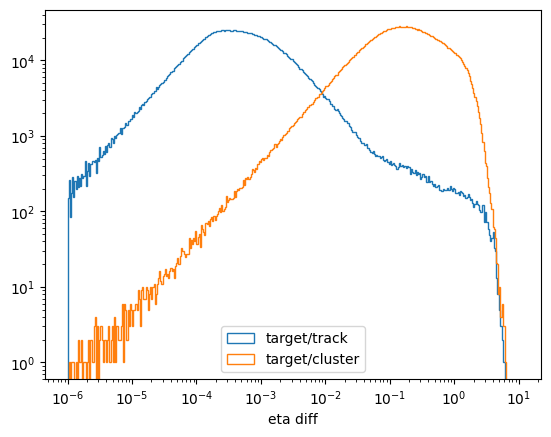

In [1506]:
b = np.logspace(-6,1,400)
plt.hist(awkward.flatten(ygen_t[:, :, 3]-X_t[:, :, 2]), bins=b, histtype="step", label="target/track");
plt.hist(awkward.flatten(ygen_c[:, :, 3]-X_c[:, :, 2]), bins=b, histtype="step", label="target/cluster");
plt.xscale("log")
plt.yscale("log")
plt.xlabel("eta diff")
plt.legend()

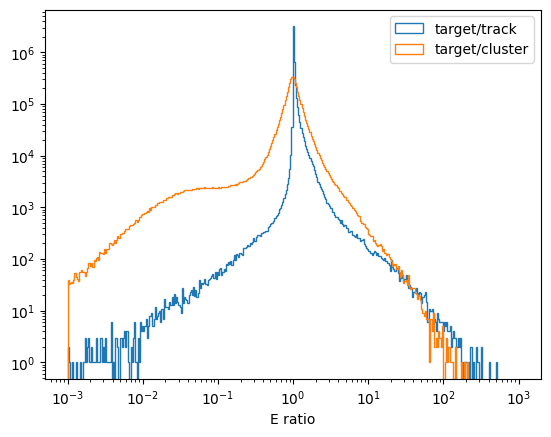

In [1507]:
b = np.logspace(-3,3,400)
plt.hist(awkward.flatten(ygen_t[:, :, 6] / X_t[:, :, 5]), bins=b, histtype="step", label="target/track");
plt.hist(awkward.flatten((ygen_c[:, :, 6] / X_c[:, :, 5])), bins=b, histtype="step", label="target/cluster");
plt.xscale("log")
plt.yscale("log")
plt.xlabel("E ratio")
plt.legend()

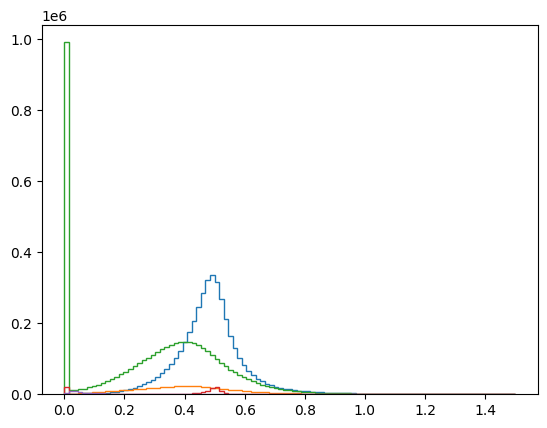

In [1508]:
b = np.linspace(0,1.5,100)
plt.hist((ygen_flat[:, -2]/ygen_flat[:, 6])[ygen_flat[:, 0]==22], bins=b, histtype="step");
plt.hist((ygen_flat[:, -2]/ygen_flat[:, 6])[ygen_flat[:, 0]==130], bins=b, histtype="step");
plt.hist((ygen_flat[:, -2]/ygen_flat[:, 6])[ygen_flat[:, 0]==211], bins=b, histtype="step");
plt.hist((ygen_flat[:, -2]/ygen_flat[:, 6])[ygen_flat[:, 0]==11], bins=b, histtype="step");
plt.hist((ygen_flat[:, -2]/ygen_flat[:, 6])[ygen_flat[:, 0]==13], bins=b, histtype="step");

In [1509]:
jetdef = fastjet.JetDefinition(fastjet.ee_genkt_algorithm, 0.4, -1.0)
min_pt = 5

def reconstruct_jets(particles):
    p4 = particles[:, :, 2:7][(particles[..., 0]!=0)]
    
    pt = p4[..., 0]
    eta = p4[..., 1]
    phi = np.arctan2(p4[..., 2], p4[..., 3])
    energy = p4[..., 4]
    
    vec_ptcls = vector.awk(
        awkward.zip(
            {   
                "pt": pt,
                "eta": eta,
                "phi": phi,
                "e": energy,
            }
        )
    )
    
    cluster = fastjet.ClusterSequence(vec_ptcls.to_xyzt(), jetdef)
    return cluster.inclusive_jets(min_pt=min_pt), cluster.constituent_index(min_pt=min_pt)

In [1510]:
jets_cand, _ = reconstruct_jets(ycand)

In [1511]:
vec_genjet = vector.awk(awkward.zip(
    {
        "pt": d["genjet"][:, :, 0],
        "eta": d["genjet"][:, :, 1],
        "phi": d["genjet"][:, :, 2],
        "energy": d["genjet"][:, :, 3],
    }
))

vec_target = vector.awk(awkward.zip(
    {
        "pt": d["targetjet"][:, :, 0],
        "eta": d["targetjet"][:, :, 1],
        "phi": d["targetjet"][:, :, 2],
        "energy": d["targetjet"][:, :, 3],
    }
))

vec_cand = vector.awk(awkward.zip(
    {
        "pt": jets_cand.pt,
        "eta": jets_cand.eta,
        "phi": jets_cand.phi,
        "energy": jets_cand.energy,
    }
))

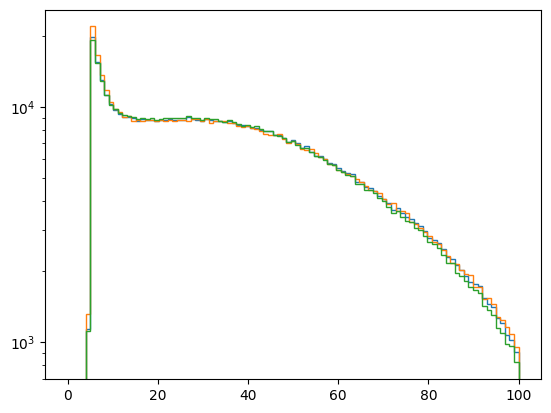

In [1512]:
b = np.linspace(0,100,100)
plt.hist(awkward.flatten(vec_genjet.pt), bins=b, histtype="step");
plt.hist(awkward.flatten(vec_cand.pt), bins=b, histtype="step");
plt.hist(awkward.flatten(vec_target.pt), bins=b, histtype="step");

plt.yscale("log")

(0.9999999854064356, 0.003800402545190873)
(1.0025863371173545, 0.061847659996217996)


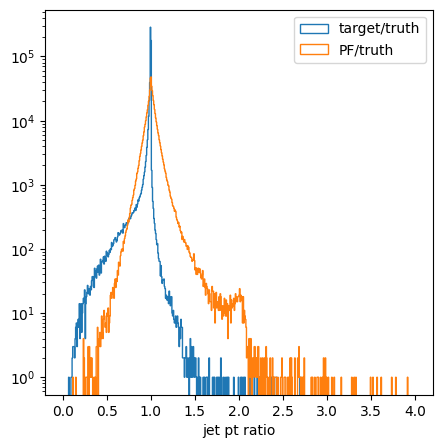

In [1519]:
b = np.linspace(0, 4, 601)

plt.figure(figsize=(5,5))

ret = jet_utils.match_jets(vec_genjet, vec_target, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])
gj_pt = awkward.flatten(vec_genjet[j1_idx].pt)
gj_eta = awkward.flatten(vec_genjet[j1_idx].eta)
tj_pt = awkward.flatten(vec_target[j2_idx].pt)
ratio = (tj_pt/gj_pt)
print(med_iqr(ratio))
plt.hist(ratio, bins=b, histtype="step", label="target/truth");

ret = jet_utils.match_jets(vec_genjet, vec_cand, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])
gj_pt = awkward.flatten(vec_genjet[j1_idx].pt)
tj_pt = awkward.flatten(vec_cand[j2_idx].pt)
ratio = (tj_pt/gj_pt)
print(med_iqr(ratio))
plt.hist(ratio, bins=b, histtype="step", label="PF/truth");

plt.legend()
plt.xlabel("jet pt ratio")
#plt.title("without status cut on target,\nfixed status=1 momentum")
plt.yscale("log")
#plt.ylim(0,200)

(0.9999999854064356, 0.003800402545190873)
(1.0025863371173545, 0.061847659996217996)


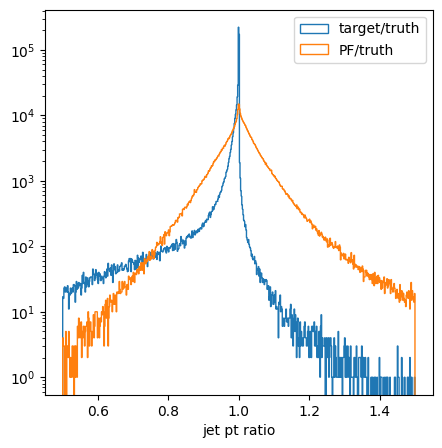

In [1514]:
b = np.linspace(0.5, 1.5, 601)

plt.figure(figsize=(5,5))

ret = jet_utils.match_jets(vec_genjet, vec_target, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])

pt_cut1 = 0
pt_cut2 = 200
gj_pt = awkward.flatten(vec_genjet[j1_idx].pt)
gj_eta = awkward.flatten(vec_genjet[j1_idx].eta)
tj_pt = awkward.flatten(vec_target[j2_idx].pt)
ratio = (tj_pt/gj_pt)[(gj_pt>pt_cut1) & (gj_pt<pt_cut2)]
print(med_iqr(ratio))
plt.hist(ratio, bins=b, histtype="step", label="target/truth");

ret = jet_utils.match_jets(vec_genjet, vec_cand, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])
gj_pt = awkward.flatten(vec_genjet[j1_idx].pt)
tj_pt = awkward.flatten(vec_cand[j2_idx].pt)
ratio = (tj_pt/gj_pt)[(gj_pt>pt_cut1) & (gj_pt<pt_cut2)]
print(med_iqr(ratio))
plt.hist(ratio, bins=b, histtype="step", label="PF/truth");

plt.legend()
plt.xlabel("jet pt ratio")
plt.yscale("log")
#plt.ylim(0,200)

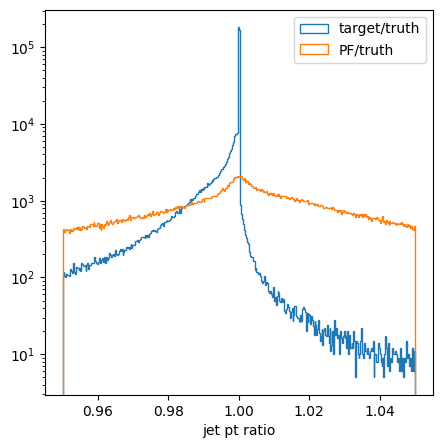

In [1515]:
b = np.linspace(0.95, 1.05, 401)

plt.figure(figsize=(5,5))

ret = jet_utils.match_jets(vec_genjet, vec_target, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])
gj_pt = awkward.flatten(vec_genjet[j1_idx].pt)
gj_eta = awkward.flatten(vec_genjet[j1_idx].eta)
tj_pt = awkward.flatten(vec_target[j2_idx].pt)
plt.hist((tj_pt/gj_pt), bins=b, histtype="step", label="target/truth");

ret = jet_utils.match_jets(vec_genjet, vec_cand, 0.1)
j1_idx = awkward.from_iter(ret[0])
j2_idx = awkward.from_iter(ret[1])
gj_pt = awkward.flatten(vec_genjet[j1_idx].pt)
tj_pt = awkward.flatten(vec_cand[j2_idx].pt)
plt.hist((tj_pt/gj_pt)[gj_pt>10], bins=b, histtype="step", label="PF/truth");

plt.legend()
plt.xlabel("jet pt ratio")
plt.yscale("log")
#plt.ylim(0,200)

(-4.0, 4.0)

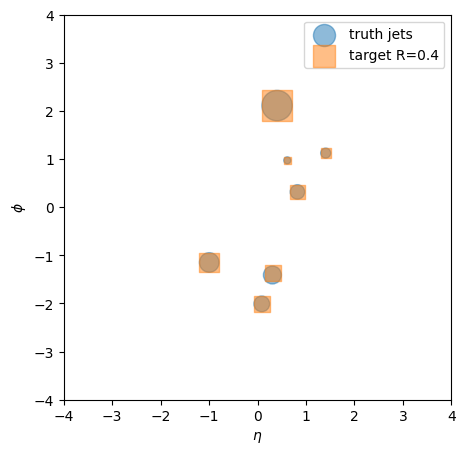

In [1529]:
iev = 20
plt.figure(figsize=(5,5))
#plt.scatter(vec_mc[iev].eta, vec_mc[iev].phi, s=5*vec_mc[iev].pt, label="MCparticles")
plt.scatter(vec_genjet[iev].eta, vec_genjet[iev].phi, s=5*vec_genjet[iev].pt, label="truth jets", alpha=0.5)
plt.scatter(vec_target[iev].eta, vec_target[iev].phi, s=5*vec_target[iev].pt, label="target R=0.4", alpha=0.5, marker="s")
#plt.scatter(jets_target_0p7[iev].eta, jets_target_0p7[iev].phi, s=5*jets_target_0p7[iev].pt, label="target R=0.7", alpha=0.5, marker="^")
plt.legend(loc="best")
plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.xlim(-4,4)
plt.ylim(-4,4)

In [ ]:
data = [
    awkward.from_parquet(f)
    for f in list(glob.glob("../../experiments/pyg-clic_20240921_171345_363520/preds_checkpoint-27-1.650469/clic_edm_ttbar_pf/pred_*.parquet"))
]
data = awkward.concatenate(data)

for field in data["jets"].fields:
    data["jets"][field] = to_p4_2(data["jets"][field])

In [ ]:
ret = {}
ret["jet_gen_to_pred_predpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["pred"][data["matched_jets"]["gen_to_pred"]["pred"]]).pt,
        axis=1,
    )
)
ret["jet_gen_to_pred_genpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["gen"][data["matched_jets"]["gen_to_pred"]["gen"]]).pt,
        axis=1,
    )
)

ret["jet_gen_to_pred_targetpte_predpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["pred_targetpte"][data["matched_jets"]["gen_to_pred_targetpte"]["pred_targetpte"]]).pt,
        axis=1,
    )
)
ret["jet_gen_to_pred_targetpte_genpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["gen"][data["matched_jets"]["gen_to_pred_targetpte"]["gen"]]).pt,
        axis=1,
    )
)

ret["jet_gen_to_pred_targetclustering_predpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["pred_targetclustering"][data["matched_jets"]["gen_to_pred_targetclustering"]["pred_targetclustering"]]).pt,
        axis=1,
    )
)
ret["jet_gen_to_pred_targetclustering_genpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["gen"][data["matched_jets"]["gen_to_pred_targetclustering"]["gen"]]).pt,
        axis=1,
    )
)

ret["jet_gen_to_pred_targetclustering2_predpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["pred_targetclustering2"][data["matched_jets"]["gen_to_pred_targetclustering2"]["pred_targetclustering2"]]).pt,
        axis=1,
    )
)
ret["jet_gen_to_pred_targetclustering2_genpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["gen"][data["matched_jets"]["gen_to_pred_targetclustering2"]["gen"]]).pt,
        axis=1,
    )
)

ret["jet_gen_to_target_targetpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["target"][data["matched_jets"]["gen_to_target"]["target"]]).pt,
        axis=1,
    )
)
ret["jet_gen_to_target_genpt"] = awkward.to_numpy(
    awkward.flatten(
        to_p4_2(data["jets"]["gen"][data["matched_jets"]["gen_to_target"]["gen"]]).pt,
        axis=1,
    )
)


In [ ]:
b = np.linspace(0.75, 1.25, 201)

fig = plt.figure(figsize=(5,5))
ax = plt.axes()

plt.hist(
    (ret["jet_gen_to_target_targetpt"] / ret["jet_gen_to_target_genpt"]),
    bins=b, histtype="step", label="target"
);

# plt.hist(
#     ret["jet_gen_to_pred_predpt"]/ ret["jet_gen_to_pred_genpt"],
#     bins=b, histtype="step", label="MLPF"
# );

# plt.hist(
#     ret["jet_gen_to_pred_targetpte_predpt"] / ret["jet_gen_to_pred_targetpte_genpt"],
#     bins=b, histtype="step", label="MLPF, target pt,E"
# );

# plt.hist(
#     ret["jet_gen_to_pred_targetclustering_predpt"] / ret["jet_gen_to_pred_targetclustering_genpt"],
#     bins=b, histtype="step", label="MLPF, target clustering"
# );

# plt.hist(
#     ret["jet_gen_to_pred_targetclustering2_predpt"] / ret["jet_gen_to_pred_targetclustering2_genpt"],
#     bins=b, histtype="step", label="MLPF, target clustering, target pt,E"
# );

plt.legend(loc="best")
#plt.yscale("log")
plt.ylim(top=ax.get_ylim()[1]*1.5)
plt.xlabel("jet pt / pt_true")
plt.axvline(1.0, color="black", ls="--", lw=0.5)

In [ ]:
iev = 3

p4_gen = to_p4(d_pred[iev]["jets"]["gen"])
p4_target = to_p4(d_pred[iev]["jets"]["target"])
p4_pred = to_p4(d_pred[iev]["jets"]["pred"])

plt.figure(figsize=(5,5))
plt.scatter(p4_gen.eta, p4_gen.phi, s=5*p4_gen.pt, label="truth")
plt.scatter(p4_target.eta, p4_target.phi, s=5*p4_target.pt, marker="s", alpha=0.5, label="target")
plt.scatter(p4_pred.eta, p4_pred.phi, s=5*p4_pred.pt, marker="^", alpha=0.5, label="MLPF")

plt.xlabel("$\eta$")
plt.ylabel("$\phi$")
plt.xlim(-4,4)
plt.ylim(-4,4)

plt.legend(loc="best", fontsize=12)

In [ ]:
X = data["inputs"]

In [ ]:
b = np.linspace(0.75, 1.25, 200)
plt.figure(figsize=(5,5))
plt.hist(awkward.flatten(data["particles"]["target"][X[:, :, 0]==1]["pt"]/X[:, :, 1][X[:, :, 0]==1]), bins=b);

In [ ]:
b = np.linspace(0,10,200)
plt.hist(awkward.flatten(data["particles"]["target"][(X[:, :, 0]==2) & (data["particles"]["target"]["cls_id"]!=0)]["pt"]), bins=b, histtype="step", lw=1);
plt.hist(awkward.flatten(X[:, :, 1][X[:, :, 0]==2]), bins=b, histtype="step", lw=1);
plt.yscale("log")

In [ ]:
b = np.linspace(0.75, 1.25, 500)
plt.figure(figsize=(5,5))
plt.hist(awkward.flatten(data["particles"]["target"][X[:, :, 0]==2]["pt"]/X[:, :, 1][X[:, :, 0]==2]), bins=b, histtype="step");

In [ ]:
b = np.linspace(0, 2, 100)
plt.figure(figsize=(5,5))

msk = (X[:, :, 0]==1) & (data["particles"]["target"]["cls_id"]==1)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

msk = (X[:, :, 0]==1) & (data["particles"]["target"]["cls_id"]==4)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

msk = (X[:, :, 0]==1) & (data["particles"]["target"]["cls_id"]==5)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

plt.yscale("log")

In [ ]:
b = np.linspace(0, 2, 100)
plt.figure(figsize=(5,5))

msk = (X[:, :, 0]==2) & (data["particles"]["target"]["cls_id"]==2)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

msk = (X[:, :, 0]==2) & (data["particles"]["target"]["cls_id"]==3)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

#plt.yscale("log")

In [ ]:
b = np.linspace(0, 2, 100)
plt.figure(figsize=(5,5))

msk = (X[:, :, 0]==2) & (data["particles"]["target"]["cls_id"]==3)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

msk = (X[:, :, 0]==2) & (data["particles"]["pred"]["cls_id"]==3)
plt.hist(awkward.flatten(data["particles"]["pred"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

#plt.yscale("log")

In [ ]:
b = np.linspace(0, 2, 100)
plt.figure(figsize=(5,5))

msk = (X[:, :, 0]==2) & (data["particles"]["target"]["cls_id"]==3)
plt.hist(awkward.flatten(data["particles"]["target"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

msk = (X[:, :, 0]==2) & (data["particles"]["pred"]["cls_id"]==3)
plt.hist(awkward.flatten(data["particles"]["pred"][msk]["energy"]/X[:, :, 5][msk]), bins=b, histtype="step");

#plt.yscale("log")